# A Restaurant Queuing Model to Inform Staffing
## Craig Chosney
## DATA 604 Final Project

### 1.  PROBLEM AND SIGNIFICANCE

I have worked in the hospitality industry for the last decade, and am currently the daytime lunch manager at a popular downtown NYC restaurant.  The COVID-19 pandemic adversely affected business at the restaurant and resulted in large cuts to staffing.  Although business at the restaurant is back up, unfortunately the staffing has not returned to its pre-pandemic "normal," and employees find themselves overworked and unable to gain shift coverage for needed time off.

Staffing at a restaurant is highly dependent on business.  For a busy shift one needs more staff, and for a slow shift one needs less.  Having the appropriate amount of staff per shift is a way to temper wage costs on slower shifts, and being appropriately staffed for busy shifts is important for customer service and sales.  Furthermore, in a tipped-wage system, overstaffing can be a detriment to an employee's take-home wages.

It is my attempt with this simulation to model customer flow at a restaurant in order to inform appropriate staffing decisions.  At the restaurant where I work, we use a daily "cover count" to predict how busy a shift will be.  A "cover count" simply refers to the amount of people you serve within the restaurant.  If the restaurant serves 100 people in a day, the restaurant is said to have done "100 covers," and the shift has a "cover count" of 100.  I have adapted code for simulating customer flow in a business to return a "cover count" for a typical five hour lunch shift at my restaurant (11 am to 4 pm), and have used my decade of experience to inform the model's logisitics and probabilities.

Having a stochastic model for simulating cover counts and customer flow will allow us to optimize staffing for both employee and employer gain.

### 2.  FLOWCHART MODEL

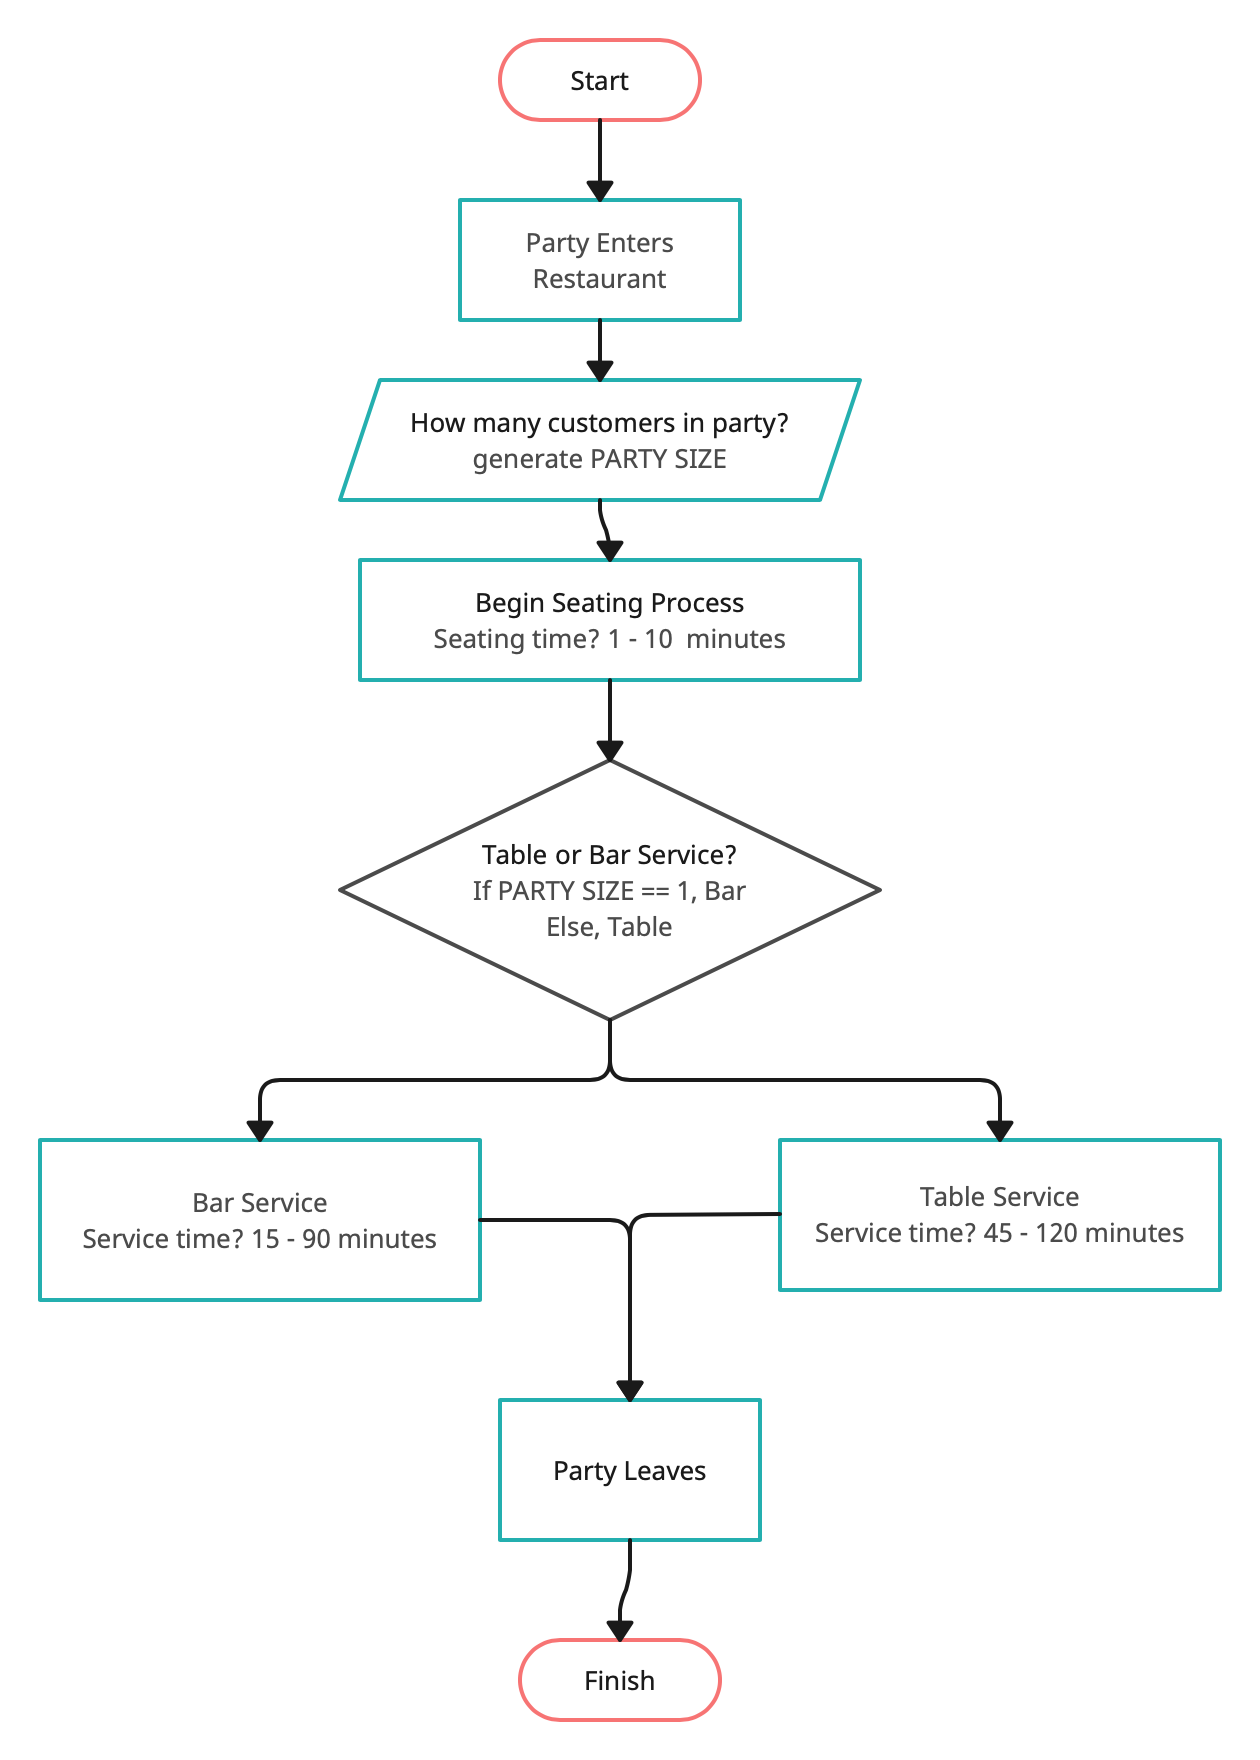

In [1]:
from IPython.display import Image
Image(filename = "chosney project flow.png", width=600, height=600)

### 3.  SIMULATION

The model simulates a month (30 days) of lunch shifts at a restaurant that offers bar seating to parties of one, and table seating to parties of two to six.  There are ten available seats at the bar, and ten available tables on the restaurant floor.  The simulation acts as follows:
- Parties enter the restaurant based on a variable arrival rate over a five hour span
- Each party is assigned a customer count based on probablities
- Parties of one are assigned to the bar, and parties of two to six are assigned to tables
- Bar service is timed randomly from 15 to 90 minutes
- Table service is timed randomly from 45 to 120 minutes
- This process iterates 30 times, representing the average amount of lunch shifts in one month

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Import required libraries
import simpy
import numpy as np
import pandas as pd
import random

In [4]:
#set seed and simulation time
seed = 700
simulation_time = 5 #Lunch service operational hours

5

In [5]:
np.random.seed(seed)
#Report here is being generated as a global variable
report = pd.DataFrame(columns = ['Party Id', 'Party Size', 'Service', 'Arrival Time', 'Seating Time', 'Service Start Time', 'Service Stop Time'])

,Party Id,Party Size,Service,Arrival Time,Seating Time,Service Start Time,Service Stop Time


In [6]:
#Function to generate arrival, 0 to 8 parties per 30 mins
def generate_interarrival(): #Arrival rate 1 - 16 per hour
    return np.random.exponential(30.0/np.random.randint(1,8))

In [7]:
#Function to generate party size, 1 - 6
def generate_party_size():
    return np.random.choice([1,2,3,4,5,6], p=[0.2,0.3,0.2,0.2,0.05,0.05])

In [8]:
#Function to return time generated for table service
def seating_service():
    return np.random.randint(1,10)

In [9]:
#Function to return time generated for table service
def table_service():
    return np.random.randint(45,120)

In [10]:
#Function to return time generated for bar service
def bar_service():
    return np.random.randint(15,90)

In [11]:
def restaurant_run(env, party_size, table, bar):
    global current_hour
    i = 0 #counter for party
   
    while True: #running time 5 hours
        
        party_size = generate_party_size()
        if party_size == 1:
            Service = 'Bar'
        else:
            Service = 'Table'
           
        i += 1
        yield env.timeout(generate_interarrival())
        env.process(party(env, i, party_size, table, bar, Service))

In [12]:
#function generates report for each party
def party(env, party, party_size, bar, table, Service):
    
    global report #access the global variable

    
    if  Service == 'Bar':
        req = bar
    else:
        req = table
    
    with bar.request() as request:
        arrival_time = env.now #starts the clock
       
        yield env.timeout(seating_service())
        seating_time = env.now #records time of seating
        
        yield request
        service_start_time = env.now #service starts 
       
        if Service == 'Bar':
            yield env.timeout(bar_service())
        else:
            yield env.timeout(table_service())
        service_stop_time = env.now 
        
    #record the data generated
        row = pd.DataFrame([['Party_{}'.format(party), party_size, Service, arrival_time, seating_time, service_start_time, service_stop_time]],
                          columns = ['Party Id', 'Party Size', 'Service', 'Arrival Time', 'Seating Time','Service Start Time', 'Service Stop Time'])
       
        report = report.append(row, ignore_index = True, sort = False)
        
    #Calculations for wait time
        report['Seating Time (Min)'] =  ( report['Seating Time'] - report['Arrival Time'])
        report['Service Time (Mins)'] =  (report['Service Stop Time'] - report['Service Start Time'])
        report['Wait Time (Mins)'] =  ( report['Service Start Time'] - report['Seating Time'] )
        

In [13]:
#Running it in a model
def model(nruns, ntable, nbar): #pass in no of runs for simulation, capacity table, capacity bar
    #initialise
    party_size=[]
    table=[] 
    bar=[]
    daily_covers_total = []
    avg_wait_time = []
    table_wait_time = []
    bar_wait_time = []
    global report
    for j in range(nruns):
        report = report[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # resource
        table = simpy.Resource(env, capacity=ntable) #assign table as resource
        bar = simpy.Resource(env, capacity=nbar) #assign bar as resource
        env.process(restaurant_run(env, party_size, table, bar))
        env.run(until = 5 * 60) #run for five hours
        
        
        Bar=report[report.Service.isin(['Bar'])] #separate to calculate mean later
        Table=report[report.Service.isin(['Table'])]
    
        daily_covers=report['Party Size'].sum()
        avg_wait=report['Wait Time (Mins)'].mean() #Calculate average time
        avg_wait_bar=Bar['Wait Time (Mins)'].mean()
        avg_wait_table=Table['Wait Time (Mins)'].mean()
    
        daily_covers_total.append(daily_covers)
        avg_wait_time.append(avg_wait)
        bar_wait_time.append(avg_wait_bar)
        table_wait_time.append(avg_wait_table)
        
    #Save in a dataframe
    new_dict = {"daily_covers": daily_covers_total, "avg_wait": avg_wait_time, "bar_wait": bar_wait_time, "table_wait": table_wait_time }
    
    global new_df
    new_df = pd.DataFrame(new_dict)

In [14]:
np.random.seed(1234)
model(30,10,10)

#the simulation is run 30 times to simulate the days in a month
#ntable = 10 tables, nbar = 10 stools


### 4. VALIDITY AND VERIFICATION

I have validated my model by comparing it to my personal experience of working in the restaurant I am simulating.  The data output by the model is very comparable to my daily experience with the actual customer flow of the restaurant.  I understand that such validation is qualitative, and that the validity of my model would be further bolstered by quantitave or mathematical comparisons.

In [23]:
report

,Party Id,Party Size,Service,Arrival Time,Seating Time,Service Start Time,Service Stop Time,Seating Time (Min),Service Time (Mins),Wait Time (Mins)
0,Party_1,1,Bar,0.961451,4.961451,4.961451,35.961451,4.0,31.0,0.000000
1,Party_2,1,Bar,6.149206,13.149206,13.149206,61.149206,7.0,48.0,0.000000
2,Party_5,4,Table,12.800125,14.800125,14.800125,81.800125,2.0,67.0,0.000000
3,Party_8,3,Table,33.830305,34.830305,34.830305,85.830305,1.0,51.0,0.000000
4,Party_6,3,Table,21.796720,27.796720,27.796720,100.796720,6.0,73.0,0.000000
5,Party_7,3,Table,22.518668,29.518668,29.518668,114.518668,7.0,85.0,0.000000
6,Party_11,2,Table,67.625603,68.625603,68.625603,117.625603,1.0,49.0,0.000000
7,Party_4,2,Table,12.005066,15.005066,15.005066,131.005066,3.0,116.0,0.000000
8,Party_3,3,Table,8.885411,17.885411,17.885411,132.885411,9.0,115.0,0.000000
9,Party_15,1,Bar,101.789906,105.789906,105.789906,142.789906,4.0,37.0,0.000000


The above report showing the details of individual party outputs for the final iteration of the simulation allows us to verify the model.  It shows that the model is behaving in the manner which I intended.  Seating and service times are within expected ranges, and parties are correctly sorted to the appropriate service by size.

### 5. CONCLUSIONS

Perhaps the most important metric for our simulation is the mean daily covers calculated over the course of our simulated month.  Using the daily cover numbers from our data frame, we see that the mean daily covers for our simulated month is 55.4.  This is the metric we would use to determine staffing policy at our restaurant.  In my experience, for the restaurant shifts I am attempting to simulate, one server can handle about 70 covers in a day.  When we see our cover count increasing to over 70, we may wish to add a second server to the shift.

Obviously the mean cover count is directly related to the frequency of arrivals that was set for the simulation.  This simulation has the frequency set for an arrival rate of 1 to 16 parties per hour.  The main benefit of this model is that one can vary this arrival rate based upon lived observation to determine a mean cover count for a set span of time (iterations).  One can then inform staffing decisions based upon this mean.  Perhaps one has observed that during the week, Monday through Thursday, this is an apt arrival rate, but that on the weekends, Saturday and Sunday, one observes that ten to 20 parties arrive per hour.  One can re-run the simulation with an arrival rate of ten to 20 parties per hour to output a mean cover count to inform a staffing model for those days that differs from the weekday staffing model.

In [16]:
new_df

,daily_covers,avg_wait,bar_wait,table_wait
0,56,1.562879,0.000000,2.344318
1,66,1.822857,3.546172,1.620114
2,36,0.000000,0.000000,0.000000
3,63,0.000000,0.000000,0.000000
4,26,0.000000,0.000000,0.000000
5,68,3.026333,3.876960,2.375854
6,40,0.023549,0.000000,0.036229
7,81,1.778273,0.000000,2.032311
8,52,0.000000,0.000000,0.000000
9,70,0.638178,0.000000,0.701996


In [17]:
print('Mean daily covers:',new_df['daily_covers'].mean())

Mean daily covers: 55.4


I have included a few more figures to inform our study.  A boxplot shows the mean and distribution of our daily covers as well as wait times for bar and table service.  

<Axes: >

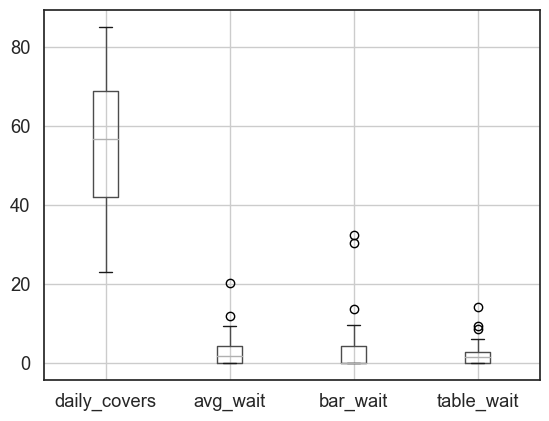

In [18]:
new_df.boxplot(grid=True, widths=0.2)

A histogram of party size frequency over the month directly correlates to the percentages set for party size distribution in the model. 

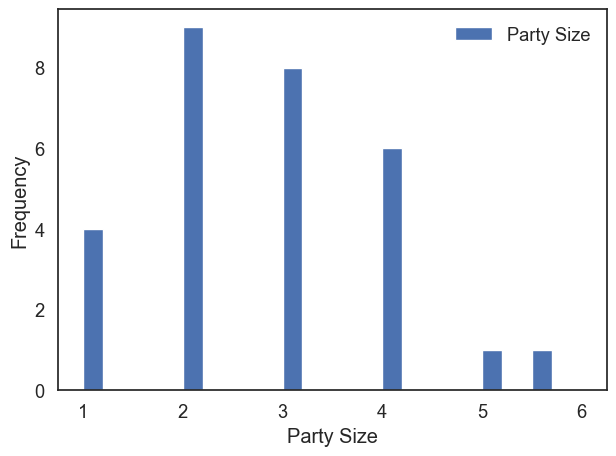

In [19]:
report['Party Size'].plot.hist(width = 0.2)
decorate(xlabel='Party Size',
         ylabel='Frequency')

A second histogram shows daily cover frequency over the month.  This histogram would also by a good way to inform staffing decisions.  One could decide to staff for the cover count that shows the highest frequency over the simulation, in this case about 68.

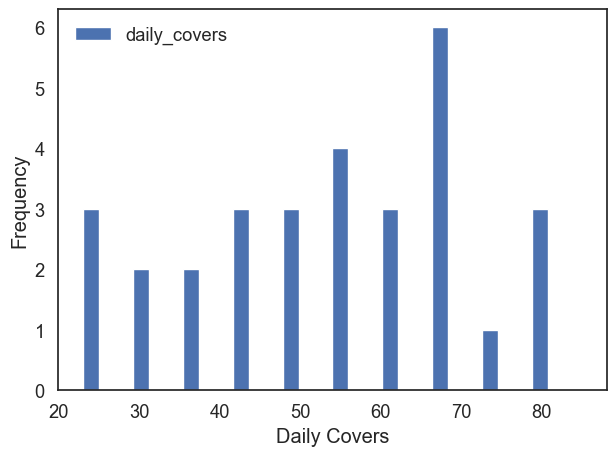

In [20]:
new_df['daily_covers'].plot.hist(width = 2)
decorate(xlabel='Daily Covers',
         ylabel='Frequency')

Finally, I have sorted our daily cover numbers in ascending order and plotted them on a bar plot to reveal a linear distribution of daily covers in our simulation.

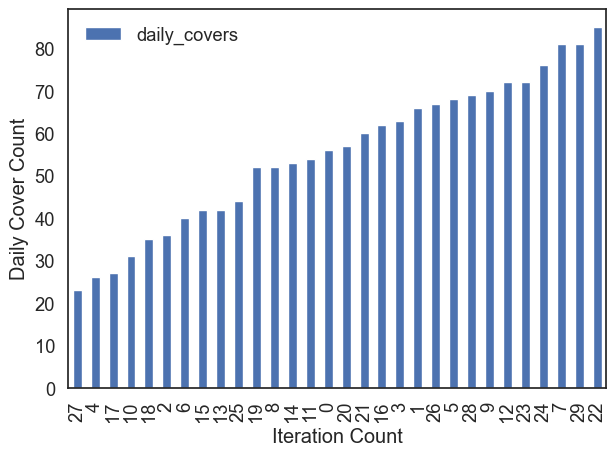

In [21]:
new_df2 = new_df.sort_values(by=['daily_covers'])
new_df2['daily_covers'].plot.bar(width = 0.5)
decorate(xlabel='Iteration Count',
         ylabel='Daily Cover Count')